# Forward modelling using simPEG
This notebook is inspired from [simPEG 2.5D Forward Simulation](https://simpeg.xyz/user-tutorials/fwd-dcr-2d) and [pyGIMLi 2D ERT modelling and inversion](https://www.pygimli.org/_examples_auto/3_ert/plot_01_ert_2d_mod_inv.html) notebooks.
## Imports and generic functions

### Imports

pyGIMLi imports

In [3]:
import pygimli as pg
import pygimli.physics.ert as ert

simPEG imports

In [4]:
from simpeg.electromagnetics.static import resistivity as dc
from simpeg import maps
from simpeg.electromagnetics.static.utils.static_utils import (
    pseudo_locations,
    plot_pseudosection,
)
from discretize import TensorMesh
from discretize.utils import active_from_xyz

Standard Python imports

In [5]:
import numpy as np
from pathlib import Path
import math
from time import perf_counter
import random as rd

Plotting imports

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.axes._axes import Axes
from matplotlib.colors import LogNorm, Normalize

### Functions

#### Mapping from a normalized log space to physical resistivity space and reciprocal

In [7]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return 2 * 10 ** (4 * log_res)
def transform(res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.log10(res / 2) / 4

#### Plotting functions

This function creates a discrete colorbar from every rock class in sample.

In [8]:
def create_colorbar(sample: np.ndarray[np.int8]) -> tuple[dict[np.int8, tuple[float, float, float, float]], mcolors.BoundaryNorm, mcolors.ListedColormap]:
    classes: np.ndarray[np.int8] = np.unique(sample)
    cmap: mcolors.ListedColormap = plt.get_cmap("tab20", len(classes))
    colors: list[tuple[float, float, float, float]] = [cmap(class_index) for class_index in range(len(classes))]
    class_color_map: dict[np.int8, tuple[float, float, float, float]] = dict(zip(classes, colors))
    norm: mcolors.BoundaryNorm = mcolors.BoundaryNorm(boundaries=np.append(classes - 0.5, classes[-1] + 0.5), ncolors=len(classes))
    cmap = mcolors.ListedColormap(colors)
    return class_color_map, norm, cmap

This function mutualizes the subplot creation

In [9]:
def sub_plot(axes: np.ndarray[Axes] | Axes,
             idx: int,
             img: np.ndarray[np.int8],
             title: str,
             class_color_map: dict[np.int8, tuple[float, float, float, float]],
             cmap_custom: mcolors.ListedColormap,
             norm: mcolors.BoundaryNorm
             ) -> None:
    if type(axes) is Axes:
        axes = np.array([axes], dtype=Axes)
    axes[idx].imshow(img, cmap=cmap_custom, norm=norm)
    legend_patches = [plt.Line2D([idx], [idx], marker='s', color='w', markerfacecolor=color, markersize=10, label=str(cls)) for cls, color in class_color_map.items()]
    axes[idx].legend(handles=legend_patches, title="Rock Labels", bbox_to_anchor=(0, 1), loc='upper left')
    axes[idx].set_title(title)
    axes[idx].set_ylabel("depth (pixels)")
    axes[idx].set_xlabel("horizontal direction (pixels)")

#### Functions to sample a subsection and resize it

The resize function uses nearest neighbour interpolation to ensure no new rock type is created.

In [10]:
def resize(sample: np.ndarray[np.int8],
           new_shape: tuple[int, int]
           ) -> np.ndarray[np.int8]:
    src_rows, src_cols = sample.shape
    dst_rows, dst_cols = new_shape

    # Compute nearest neighbor indices
    row_indices = np.round(np.linspace(0, src_rows - 1, dst_rows)).astype(int)
    col_indices = np.round(np.linspace(0, src_cols - 1, dst_cols)).astype(int)

    # Use advanced indexing to select nearest neighbors
    resized_array = sample[row_indices[:, None], col_indices]

    return resized_array

def create_random_slice(max_length: int,
                        fraction: float
                        ) -> slice:
    start: int = rd.randint(0, int(max_length * (1 - fraction)))
    return slice(start, start + int(max_length * fraction))

def extract_random_subsection(section: np.ndarray[np.int8],
                              total_pixels_to_keep: int,
                              vertical_fraction: float = 1.,
                              ) -> np.ndarray[np.int8]:
    # Vertical part
    depth_slice: slice = create_random_slice(section.shape[0], vertical_fraction)

    # Horizontal part
    horizontal_fraction: float = total_pixels_to_keep / section.shape[1]
    width_slice: slice = create_random_slice(section.shape[1], horizontal_fraction)

    return section[depth_slice, width_slice], depth_slice, width_slice

#### Function to define Schlumberger and Wenner arrays

These functions are only mandatory for simPEG, as simPEG makes dipole-dipole arrays by default.

In [11]:
def schlumberger_array(nbr_electrodes: int,
                       electrode_locations: np.ndarray[np.float64],
                       data_type: str
                       ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, nbr_electrodes // 2):
        locations_a = electrode_locations[:(-2 * a) - 1]
        locations_b = electrode_locations[(2 * a) + 1:]
        locations_m = electrode_locations[a:-a - 1]
        locations_n = electrode_locations[a + 1:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]
        source_list += source_list_a
    return source_list

def wenner_array(nbr_electrodes: int,
                 electrode_locations: np.ndarray[np.float64],
                 data_type: str
                 ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, (nbr_electrodes + 3) // 3 + 1):
        locations_a = electrode_locations[:-3 * a:]
        locations_b = electrode_locations[3 * a:]
        locations_m = electrode_locations[a:-2 * a:]
        locations_n = electrode_locations[2 * a:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]

        source_list += source_list_a
    return source_list

#### Function to get pseudosections from flat results

For Wenner arrays:

In [12]:
def compute_active_columns(row: int, is_even_row: bool, total_cols: int, offset: int) -> tuple[int, int]:
    """
    Compute the starting and ending column indices for the given row.
    """
    if is_even_row:
        col_start = math.ceil(row * 1.5) - offset
        col_end = total_cols - math.ceil(row * 1.5) + offset
    else:
        col_start = math.ceil((row + 1) * 1.5) - 1 - offset
        col_end = total_cols - math.ceil((row + 1) * 1.5) + 1 + offset
    return col_start, col_end

def process_pseudo_section_wenner_array(rhoa: list[float],
                                        nbr_electrodes: int
                                        ) -> np.ndarray[np.float64]:
    num_rows: int = (nbr_electrodes - 1) // 3
    num_cols: int = nbr_electrodes - 3

    even_num_cols: bool = (num_cols % 2 == 0)
    if even_num_cols:
        # We want non even number of columns to be able to center the
        # triangle.
        num_cols += 1

    offset: int = (nbr_electrodes - 1) % 2

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_rows, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)
    value_index: int = 0

    for i in range(num_rows):
        # Determine if the current row is considered "even" based on num_cols
        # parity
        is_even_row = (i % 2 == 0) if even_num_cols else (i % 2 == 1)

        col_start, col_end = compute_active_columns(
            i, is_even_row, num_cols, offset)

        for j in range(col_start, col_end):
            # For even rows, use a special average at the center column
            if is_even_row and j == (num_cols - 1) // 2:
                pseudo_section[i, j] = (
                    rhoa[value_index - 1] + rhoa[value_index]) / 2
            else:
                pseudo_section[i, j] = rhoa[value_index]
                value_index += 1
    return pseudo_section

For Schlumberger arrays

In [13]:
def process_pseudo_section_schlumberger_array(rhoa: list[float],
                                              nbr_electrodes: int
                                              ) -> np.ndarray[np.float64]:
    num_cols: int = nbr_electrodes - 3
    num_lines: int = nbr_electrodes // 2 - 1

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_lines, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)

    value_index: int = 0
    for i in range(num_lines):
        start_col: int = i
        end_col: int = num_cols - i
        num_values_this_row: int = end_col - start_col
        pseudo_section[i, start_col:end_col] = rhoa[value_index: value_index +
                                                    num_values_this_row]
        value_index += num_values_this_row

    return pseudo_section

## Data paths

In [14]:
dataset_path: Path = Path("../../../clean_reduced_unified")

Get the number or npz archive.

In [15]:
nbr_npz: int = len(list(dataset_path.glob("*.npz")))
print(f"{nbr_npz} files found")

61 files found


## Geological model

### Random geological model selection

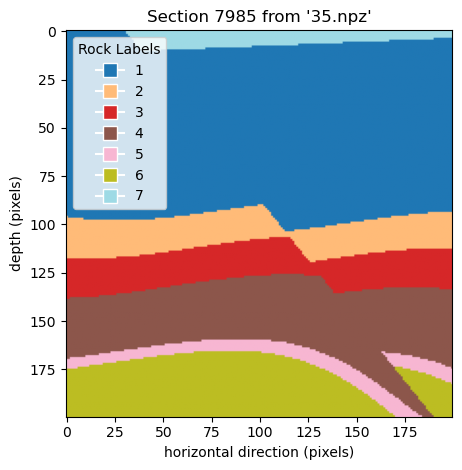

In [16]:
# Choose a random file
npz_idx: int = rd.randint(0, nbr_npz)
# Load the numpy array
multi_array: np.ndarray[np.int8] = np.load(dataset_path / f"{npz_idx}.npz", mmap_mode='r')["arr_0"]
# Choose a random section in this array
section_idx: int = rd.choice(range(len(multi_array)))
# Extract the section
section: np.ndarray[np.int8] = multi_array[section_idx]

# Plot the section
fig, ax = plt.subplots(1, 1)
class_color_map, norm, cmap_custom = create_colorbar(section)
sub_plot(ax, 0, section, f"Section {section_idx} from '{npz_idx}.npz'", class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

### Random configuration
Random number of electrodes and random subsection.
We keep 3 pixels between each electrodes and we pad 6 (2 times 3) pixels on each side (so 12 pixels in total)

In [17]:
# Choose a random number of electrodes 24 <= n <= 96
num_electrodes: int = rd.randint(24, 97)
# Choose a random length of the subsection to keep num_electrodes - 1 <= n <= horizontal section length
total_pixels_to_keep: int = rd.randint(num_electrodes - 1, section.shape[1])

# Number of pixels between each electrodes
inter_electrode_num_pixels: int = 3
# Number of pixels padding on each side of the section
lateral_padding: int = inter_electrode_num_pixels * 2
# This is the final horizontal section length we want
total_pixels_after_refinement: int = (num_electrodes - 1) * inter_electrode_num_pixels + 2 * lateral_padding

print(f"Number of electrodes: {num_electrodes}")
print(f"Subsection length: {total_pixels_to_keep}")
print(f"Number of pixels between each electrodes: {inter_electrode_num_pixels}")
print(f"Number of padding pixels on each side: {lateral_padding} (total: {2 * lateral_padding})")
print(f"Total pixels after refinement: {total_pixels_after_refinement}")

Number of electrodes: 93
Subsection length: 137
Number of pixels between each electrodes: 3
Number of padding pixels on each side: 6 (total: 12)
Total pixels after refinement: 288


We can then extract a random subsection from our section.

Depth slice: slice(77, 177, None)
Width slice: slice(24, 161, None)


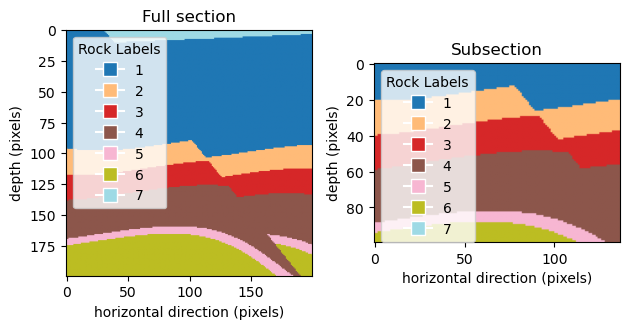

In [18]:
# What fraction of the initial section we want to keep
vertical_fraction: float = 0.5
# Extract the subsection
sub_section, depth_slice, width_slice = extract_random_subsection(section, total_pixels_to_keep, vertical_fraction)
print(f"Depth slice: {depth_slice}")
print(f"Width slice: {width_slice}")

# Plot the section and the subsection
fig, ax = plt.subplots(1, 2)
class_color_map, norm, cmap_custom = create_colorbar(section)
titles: list[str] = [f"Full section", f"Subsection"]
for idx, (img, title) in enumerate(zip([section, sub_section], titles)):
    sub_plot(ax, idx, img, title, class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

And then, to ensure we have at least (in fact exactly) inter_electrode_num_pixels pixels between each electrodes, we resize the subsection. We make sure that the width/depth ratio is vertical_fraction.

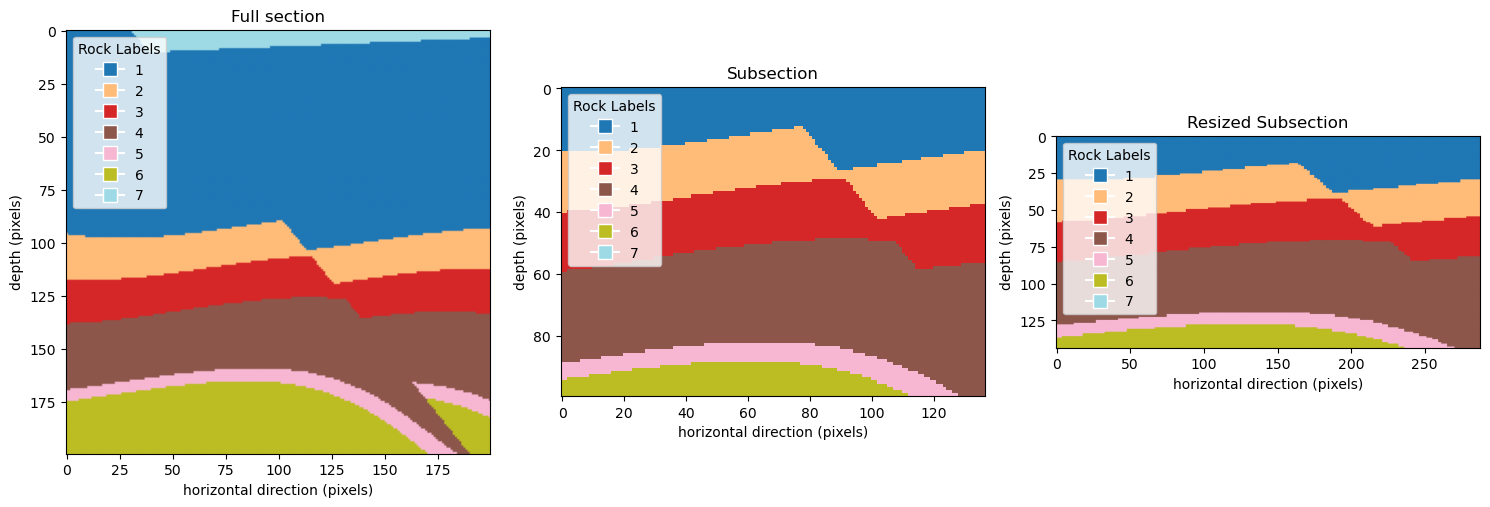

In [19]:
vertical_size: int = int(vertical_fraction * total_pixels_after_refinement)
# Resize the section
sub_section_resized: np.ndarray[np.int8] = resize(sub_section, (vertical_size, total_pixels_after_refinement))

# Plot the section, the subsection and the resized subsection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_color_map, norm, cmap_custom = create_colorbar(section)
titles: list[str] = [f"Full section", f"Subsection", f"Resized Subsection"]
for idx, (img, title) in enumerate(zip([section, sub_section, sub_section_resized], titles)):
    sub_plot(axes, idx, img, title, class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

## Resistivity assignation
We assign each rock class a random resistivity. The resistivity value is sampled from a uniform distribution on $ \left[0, 1\right] $ and mapped using a logarithm function to $ \left[2, 20000\right] $.

In [20]:
# Extract the rock classes
rock_classes, inv = np.unique(sub_section_resized, return_inverse=True)
# Create a random normalized log resistivity value for each rock class
norm_log_res_values: np.ndarray[np.float64] = np.random.uniform(0, 1, size=len(rock_classes))
# Assign the random log resistivity value to each pixel according to its rock class
norm_log_resistivity_model: np.ndarray[np.float64] = norm_log_res_values[inv].reshape(sub_section_resized.shape)
# Detransform the resistivity values
resistivity_model: np.ndarray[np.float64] = detransform(norm_log_resistivity_model)

Just plotting and printing the resistivities.

Rock class 1 with normalized log resistivity 0.6611207838274126 and resistivity 882.0904719013348 ohm.m
Rock class 2 with normalized log resistivity 0.5757476607286205 and resistivity 401.80990523894485 ohm.m
Rock class 3 with normalized log resistivity 0.19406801897154857 and resistivity 11.948188663386667 ohm.m
Rock class 4 with normalized log resistivity 0.10361930459135837 and resistivity 5.194063012500967 ohm.m
Rock class 5 with normalized log resistivity 0.7851017472533796 and resistivity 2763.356932122689 ohm.m
Rock class 6 with normalized log resistivity 0.3556255110171329 and resistivity 52.90930291902798 ohm.m


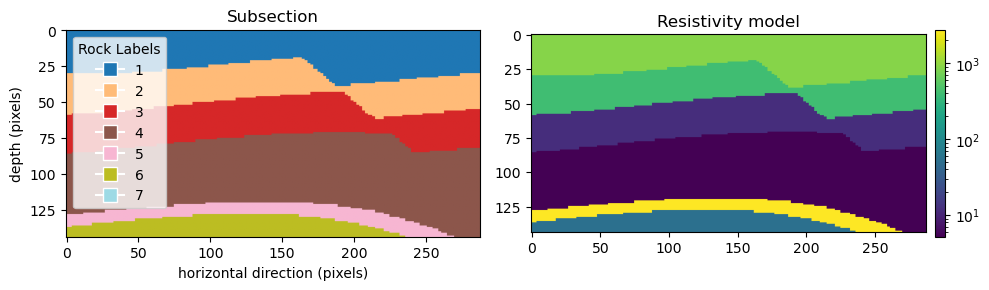

In [21]:
# Print the normalized log resistivity and the resistivity values
for rock_class, norm_log_res in zip(rock_classes, norm_log_res_values):
    print(f"Rock class {rock_class} with normalized log resistivity {norm_log_res} and resistivity {detransform(norm_log_res)} ohm.m")

# Plot the resized subsection and the resistivity model
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sub_plot(axes, 0, sub_section_resized, f"Subsection", class_color_map, cmap_custom, norm)
img = axes[1].imshow(resistivity_model, cmap="viridis", norm=mcolors.LogNorm())
axes[1].set_title(f"Resistivity model")
fig.colorbar(img, ax=axes[1], orientation='vertical', fraction=0.025, pad=0.02)
plt.tight_layout()
plt.show()

We need to flatten resistivity models to map it to the mesh. Additionnally, the axis of the mesh are flipped compared to the resistivity model.

In [22]:
resistivity_model_flat = np.flipud(resistivity_model).ravel()
norm_log_resistivity_model_flat = np.flipud(norm_log_resistivity_model).ravel()

## Mesh creation

simPEG uses discretize Mesh class. 

In [23]:
# Specify the length and the number of cells in the horizontal direction
hx = [(1, total_pixels_after_refinement)]
# Specify the length and the number of cells in the vertical direction
# hz = [(1, vertical_size)]
hz = [(1, vertical_size)]
# Create the tensor mesh, origin is at the top left corner
mesh = TensorMesh((hx, hz), origin="0N")

pyGIMLi handles meshes internally.

In [24]:
# Create the x coordinates
x_arr: np.ndarray[np.float64] = np.linspace(0., total_pixels_after_refinement, total_pixels_after_refinement + 1, dtype=np.float64)
# Create the z coordinates
z_arr: np.ndarray[np.float64] = np.linspace(-vertical_size, 0, vertical_size + 1, dtype=np.float64)
# Create the mesh, worldBoundaryMarker=True sets homogeneous Neumann boundary conditions to subsurface boundaries and Dirichlet to the surface interface.
world: pg.core.Mesh = pg.createGrid(x=x_arr, y=z_arr, worldBoundaryMarker=True)

We can then plot the two meshes.

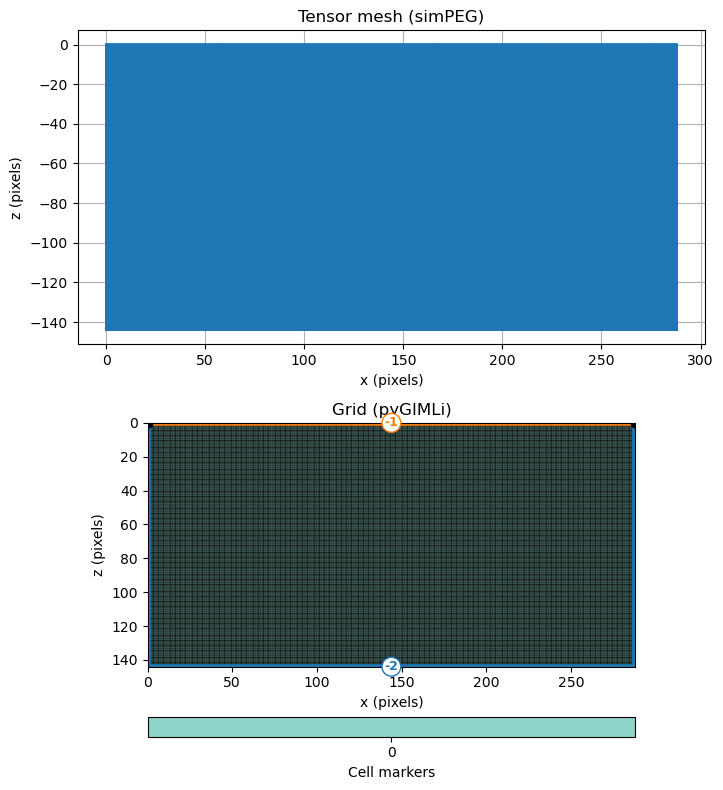

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
mesh.plot_grid(ax=axes[0])
axes[0].set_title("Tensor mesh (simPEG)")
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].set_aspect("equal")

axes[1].set_aspect("equal")
pg.show(world, showMesh=True, markers=True, ax=axes[1])
axes[1].set_title("Grid (pyGIMLi)")
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
plt.tight_layout()
plt.show()

## Arrays creation

With simPEG

In [29]:
# Define the measurement data type
data_type = "apparent_resistivity"

# Define electrode locations
electrode_locations_x_simPEG = np.linspace(lateral_padding, total_pixels_after_refinement - lateral_padding, num_electrodes)
electrode_locations_z_simPEG = np.zeros_like(electrode_locations_x_simPEG)
electrode_locations_simPEG = np.c_[electrode_locations_x_simPEG, electrode_locations_z_simPEG]

array = schlumberger_array
# array = wenner_array
source_list = array(num_electrodes, electrode_locations_simPEG, data_type)

# Define survey
survey = dc.Survey(source_list)

With pyGIMLi

In [30]:
# Define scheme
scheme_name: str = "wa" if array == wenner_array else "slm"

# Define electrode locations
elec_array: np.float64 = np.linspace(lateral_padding, total_pixels_after_refinement - lateral_padding, num_electrodes, dtype=np.float64)
# Create the data container
scheme: pg.DataContainerERT = ert.createData(elecs=elec_array, schemeName=scheme_name)

Let's plot the results:

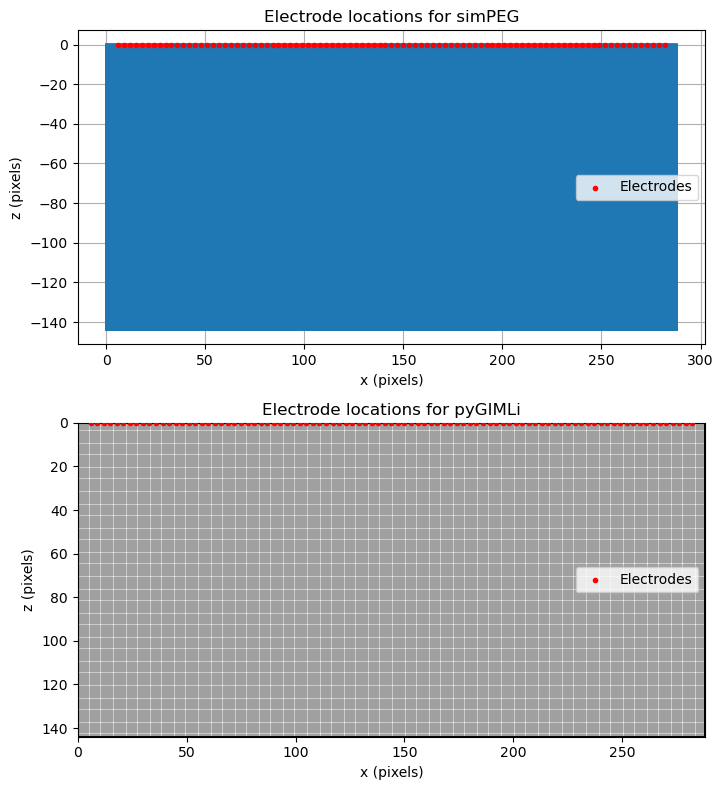

In [31]:
# With pyGIMLi, the electrode locations are not directly accessible from the scheme object so let's store them in an array. 
electrode_locations_pyGIMLi: np.ndarray[np.float64] = np.array([scheme.sensorPosition(i) for i in range(scheme.sensorCount())])

# Plot the electrode locations for both simPEG and pyGIMLi
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
mesh.plot_grid(ax=axes[0])
axes[0].scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, marker='.', color='red', label='Electrodes', zorder=10)
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].set_title("Electrode locations for simPEG")
axes[0].set_aspect("equal")
axes[0].legend(loc="center right")

pg.show(world, ax=axes[1], showMesh=True)
axes[1].scatter(electrode_locations_pyGIMLi[:, 0], electrode_locations_pyGIMLi[:, 1], marker='.', color='red', label='Electrodes', zorder=10)
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
axes[1].set_title(f"Electrode locations for pyGIMLi")
axes[1].set_aspect("equal")
axes[1].legend(loc="center right")

plt.tight_layout()
plt.show()

## Topography

Topography is mandatory for simPEG, so let's create one.

In [32]:
# Create x coordinates
x_topo = np.linspace(0, total_pixels_after_refinement, total_pixels_after_refinement)
# We want a flat topography
z_topo = np.zeros_like(x_topo)
# Create the 2D topography
topo_2d = np.c_[x_topo, z_topo]

And plot it:

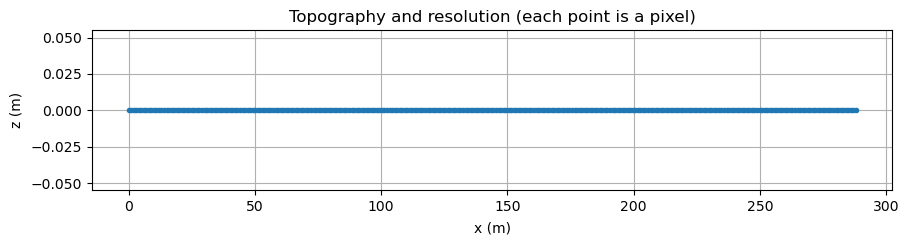

In [33]:
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, marker=".")
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and resolution (each point is a pixel)")
plt.show(fig)

Now we active every cell as they all participate to the modelling.

In [34]:
# We activate all cells below the surface
active_cells = active_from_xyz(mesh, topo_2d)

To map resistivity model to mesh, we need to use an IdentityMap.

In [35]:
# Multiplying the resistivity map with the resistivity model (without air layer) will associate the resistivity value to the active cells
resistivity_map = maps.IdentityMap(mesh, nP=mesh.n_cells)

## Plot the mesh, the resistivity model and the electrodes

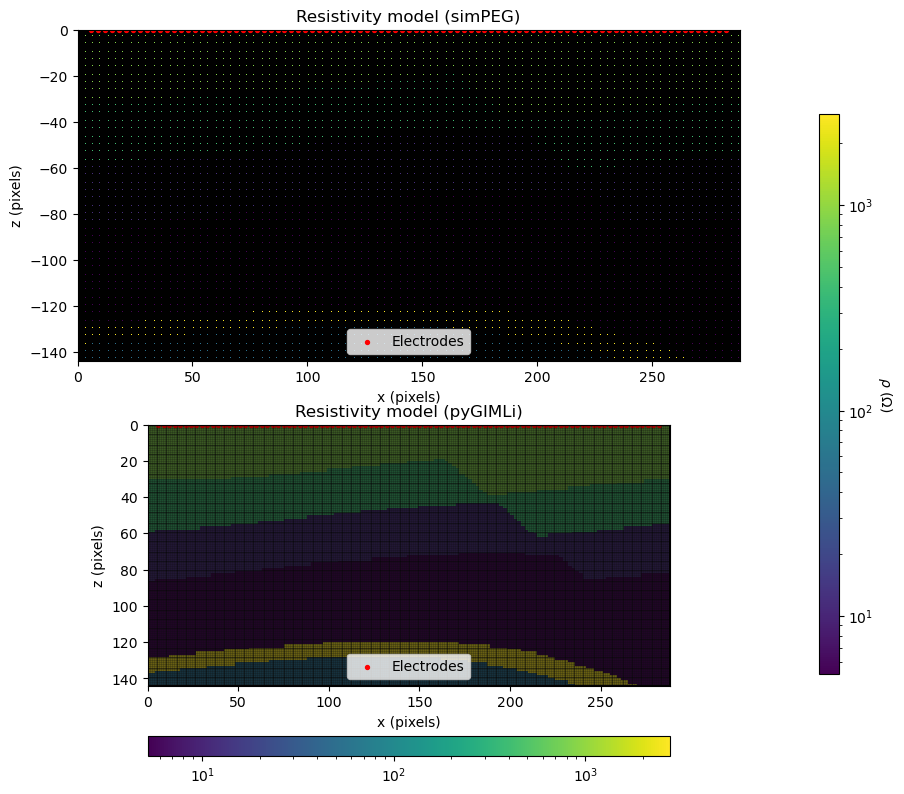

In [36]:
plotting_map = maps.IdentityMap(mesh, mesh.n_cells)

# Plot the resistivity model on the mesh
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

norm = LogNorm(vmin=np.min(resistivity_model_flat), vmax=np.max(resistivity_model_flat))
mesh_plot = mesh.plot_image(plotting_map * resistivity_model_flat, ax=axes[0], grid=True)
for grid_line in mesh_plot:
    grid_line.set_linewidth(0.1)  # Change the grid line width
mesh_plot[0].set_norm(norm)
axes[0].set_title("Resistivity model (simPEG)")
axes[0].scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, 8, "r", label="Electrodes")
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].set_aspect("equal")
axes[0].legend(loc="lower center")

pg.show(world, data=resistivity_model_flat, showMesh=True, ax=axes[1], norm=norm)
axes[1].collections[0].set_norm(norm)
axes[1].scatter(electrode_locations_pyGIMLi[:, 0], electrode_locations_pyGIMLi[:, 1], 8, "r", label="Electrodes")
axes[1].set_title("Resistivity model (pyGIMLi)")
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
axes[1].set_aspect("equal")
axes[1].legend(loc="lower center")

# Add a shared colorbar between both subplots
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Position for the colorbar
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, norm=norm)
cbar.set_label(r"$\rho$ ($\Omega$)", rotation=270, labelpad=15)

plt.show()

## Some simPEG steps more...
We ensure electrodes are on the mesh, compute the geometric factors and create the simulation object.

In [37]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top", topography=topo_2d)
_ = survey.set_geometric_factor()
resistivity_simulation = dc.simulation_2d.Simulation2DNodal(mesh, survey=survey, rhoMap=resistivity_map)

## Forward step

In [38]:
## simPEG
start_time_simPEG = perf_counter()
forward_model_simPEG = resistivity_simulation.dpred(resistivity_model_flat)
stop_time_simPEG = perf_counter()

## pyGIMLi
start_time_pyGIMLi = perf_counter()
forward_model_pyGIMLi = ert.simulate(world, res=resistivity_model_flat, scheme=scheme, verbose=True)
stop_time_pyGIMLi = perf_counter()

/root/miniconda3/envs/both_forward/lib/python3.11/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


ModellingBase::setMesh() copying new mesh ... Found datafile: 93 electrodes
Found: 93 free-electrodes
rMin = 1.5, rMax = 552
NGauLeg + NGauLag for inverse Fouriertransformation: 15 + 4
Found non-Neumann domain
0.321655 s
FOP updating mesh dependencies ... 3.6e-06 s
Calculating response for model: min = 5.19406 max = 2763.36
Allocating memory for primary potential...... 0.132754

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 49.9736s
Response: min = 111.748 max = 882.066 mean = 615.78
Reciprocity rms(modelReciprocity) 1.52148%, max: 16.4389%


Print the forward modelling timer.

In [39]:
print(f"Forward time simPEG: {stop_time_simPEG - start_time_simPEG}")
print(f"Forward time pyGIMLi: {stop_time_pyGIMLi - start_time_pyGIMLi}")

Forward time simPEG: 98.14472192700032
Forward time pyGIMLi: 50.95513153000047


## Result visualisation

Here we visualize the pseudosection using the tools furnished by the libraries.

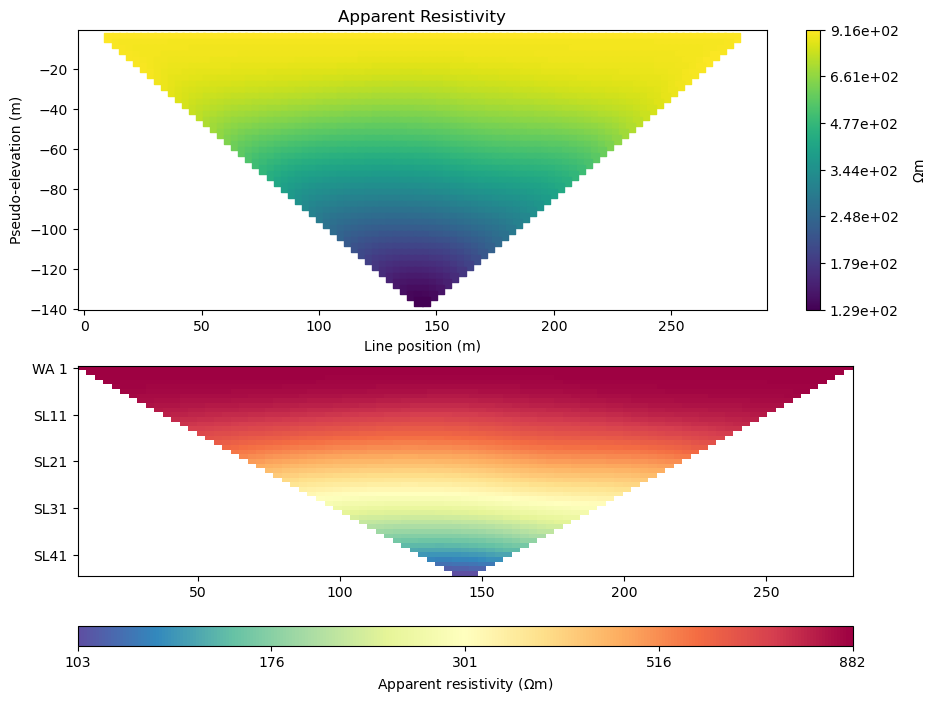

In [40]:
# Plot apparent resistivity pseudo-section
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_pseudosection(
    survey,
    dobs=forward_model_simPEG,
    ax=axes[0],
    scale="log",
    cbar_label="$\Omega$m",
    plot_type="scatter",
    scatter_opts={"marker": "s"},
)
axes[0].set_title("Apparent Resistivity")

ert.showERTData(forward_model_pyGIMLi, ax=axes[1])

plt.show()

And now we visualize with our custom functions.

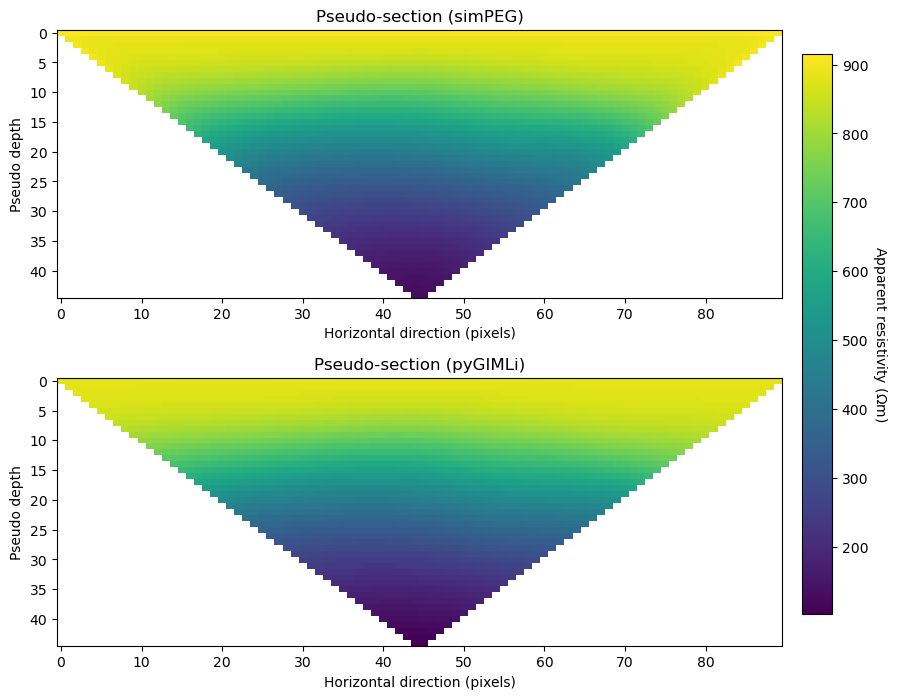

In [41]:
if array == wenner_array:
    process_pseudo_section = process_pseudo_section_wenner_array
else:
    process_pseudo_section = process_pseudo_section_schlumberger_array

pseudo_section_simPEG = process_pseudo_section(forward_model_simPEG, num_electrodes)
pseudo_section_pyGIMLi = process_pseudo_section(forward_model_pyGIMLi['rhoa'], num_electrodes)

vmin = min(np.nanmin(pseudo_section_simPEG), np.nanmin(pseudo_section_pyGIMLi))
vmax = max(np.nanmax(pseudo_section_simPEG), np.nanmax(pseudo_section_pyGIMLi))
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot the pseudo-sections
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
im0 = axes[0].imshow(pseudo_section_simPEG, cmap="viridis", norm=norm)
axes[0].set_title("Pseudo-section (simPEG)")
axes[0].set_ylabel("Pseudo depth")
axes[0].set_xlabel("Horizontal direction (pixels)")
axes[0].set_aspect("auto")

im1 = axes[1].imshow(pseudo_section_pyGIMLi, cmap="viridis", norm=norm)
axes[1].set_title("Pseudo-section (pyGIMLi)")
axes[1].set_ylabel("Pseudo depth")
axes[1].set_xlabel("Horizontal direction (pixels)")
axes[1].set_aspect("auto")

# Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.3, right=0.85)

# Add a joint colorbar for both subplots
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Adjusted position for the colorbar
cbar = fig.colorbar(im1, cax=cbar_ax, norm=norm)  # Use im1 to create a joint colorbar
cbar.set_label("Apparent resistivity ($\Omega$m)", rotation=270, labelpad=15)

plt.show()

Let's plot the differences between the 2 pseudosections.

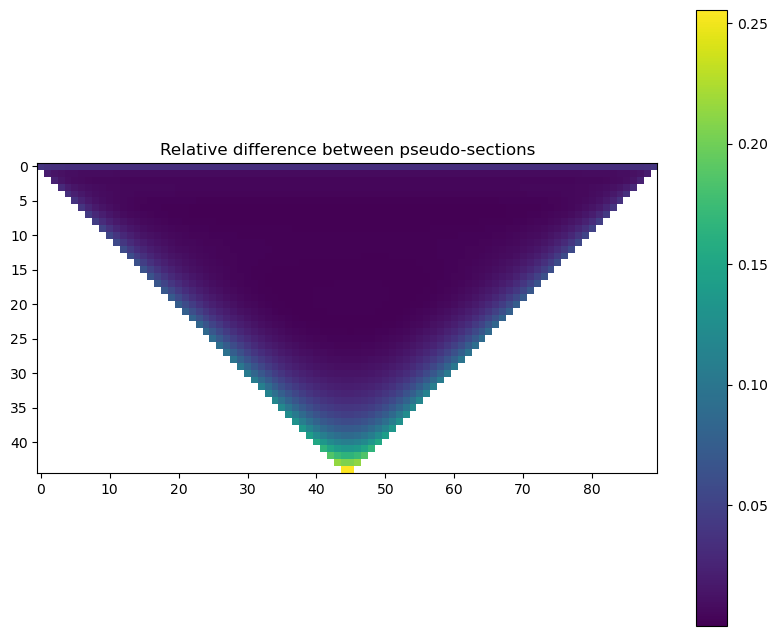

In [42]:
plt.figure(figsize=(10, 8))
plt.imshow(np.abs(pseudo_section_simPEG - pseudo_section_pyGIMLi) / pseudo_section_pyGIMLi, cmap="viridis")
plt.colorbar()
plt.title("Relative difference between pseudo-sections")
plt.show()

## simPEG with an air layer

The [simPEG 2.5D Forward Simulation notebook](https://simpeg.xyz/user-tutorials/fwd-dcr-2d) uses an air layer of inactive highly resistive cells. Let's see if this makes a difference for our case.
We add a 10 rows air layer with a resistivity of $10^8 \Omega m$.

In [43]:
air_layer_thickness = 10
air_resistivity = 1e8
air_layer = np.full((air_layer_thickness, resistivity_model.shape[1]), air_resistivity, dtype=float)
resistivity_model_air = np.vstack((air_layer, resistivity_model))
resistivity_model_air_flat = np.flipud(resistivity_model_air).ravel()

We create a new mesh with 10 rows of air layer, so we put origin at level 10.

In [44]:
hz = [(1, resistivity_model_air.shape[0])]
mesh_air = TensorMesh((hx, hz), origin="0N")
mesh_air.origin += [0, air_layer_thickness]

We activate the cells below the surface (0).

In [45]:
# We activate all cells below the surface
active_cells_air = active_from_xyz(mesh_air, topo_2d)

We use an Injective map to set the inactive cells to air_resistivity and map the resistivity models without air layer to the subsurface.

In [46]:
# Multiplying the resistivity map with the resistivity model (without air layer) will associate the resistivity value to the active cells
resistivity_map_air = maps.InjectActiveCells(mesh_air, active_cells_air, air_resistivity)

We ensure electrodes are on the interface and create the simulation object.

In [47]:
survey.drape_electrodes_on_topography(mesh_air, active_cells_air, option="top", topography=topo_2d)
_ = survey.set_geometric_factor()
resistivity_simulation_air = dc.simulation_2d.Simulation2DNodal(mesh_air, survey=survey, rhoMap=resistivity_map_air)

Forward step.

In [48]:
start_time_simPEG = perf_counter()
forward_model_simPEG_air = resistivity_simulation_air.dpred(resistivity_model_flat)
stop_time_simPEG = perf_counter()

/root/miniconda3/envs/both_forward/lib/python3.11/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: Mumps. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)


In [49]:
print(f"Forward time simPEG: {stop_time_simPEG - start_time_simPEG}")

Forward time simPEG: 111.64059555899985


Let's plot the pseudosection.

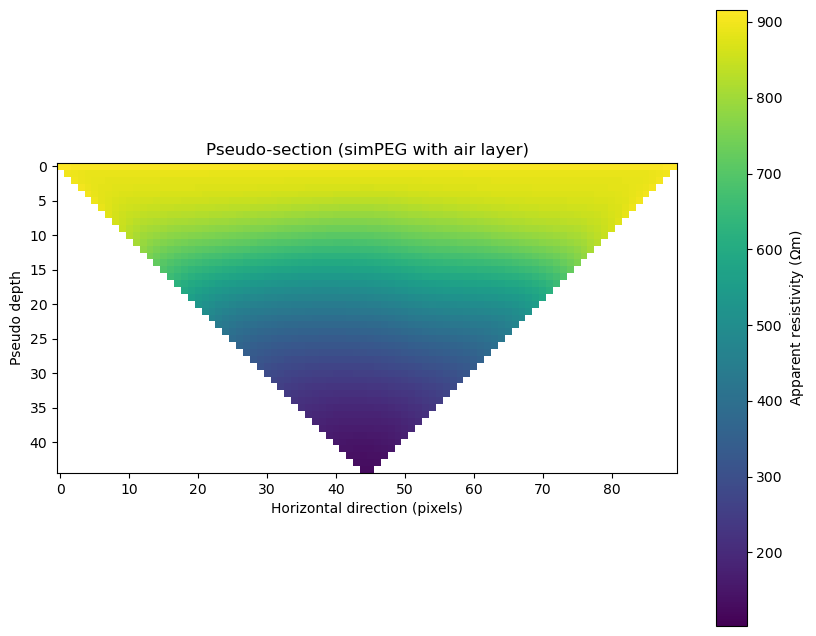

In [50]:
if array == wenner_array:
    process_pseudo_section = process_pseudo_section_wenner_array
else:
    process_pseudo_section = process_pseudo_section_schlumberger_array

pseudo_section_simPEG_air = process_pseudo_section(forward_model_simPEG_air, num_electrodes)

vmin = min(np.nanmin(pseudo_section_simPEG), np.nanmin(pseudo_section_pyGIMLi))
vmax = max(np.nanmax(pseudo_section_simPEG), np.nanmax(pseudo_section_pyGIMLi))
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot the pseudo-sections
fig = plt.figure(figsize=(10, 8))
plt.imshow(pseudo_section_simPEG, cmap="viridis", norm=norm)
plt.title("Pseudo-section (simPEG with air layer)")
plt.ylabel("Pseudo depth")
plt.xlabel("Horizontal direction (pixels)")

plt.colorbar(norm=norm, label=r"Apparent resistivity ($\Omega$m)")

plt.show()

### Difference between forward modelling with and without air layer

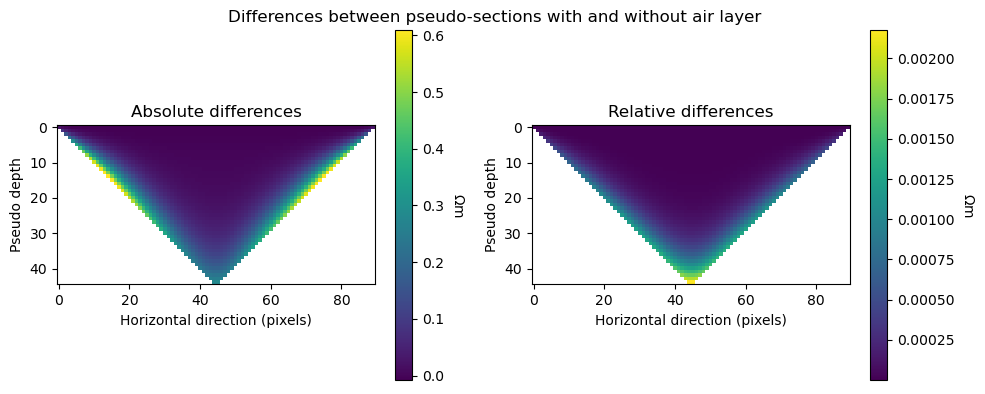

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
img0 = ax[0].imshow(pseudo_section_simPEG_air - pseudo_section_simPEG, cmap="viridis")
ax[0].set_title("Absolute differences")
ax[0].set_ylabel("Pseudo depth")
ax[0].set_xlabel("Horizontal direction (pixels)")
cbar0 = plt.colorbar(img0, ax=ax[0], label=r"Apparent resistivity ($\Omega$m)", shrink=0.5)
cbar0.set_label(r"$\Omega$m", rotation=270, labelpad=15)

img1 = ax[1].imshow(np.abs(pseudo_section_simPEG_air - pseudo_section_simPEG) / pseudo_section_simPEG, cmap="viridis")
ax[1].set_title("Relative differences")
ax[1].set_ylabel("Pseudo depth")
ax[1].set_xlabel("Horizontal direction (pixels)")
cbar1 = plt.colorbar(img1, ax=ax[1], label=r"Apparent resistivity ($\Omega$m)", shrink=0.5)
cbar1.set_label(r"$\Omega$m", rotation=270, labelpad=15)

fig.suptitle("Differences between pseudo-sections with and without air layer", y=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Solver

Last versions use Pardiso or Mumps that are highly multi-threaded. But on eXplor (Université de Lorraine supercomputer), the old OS makes the use of SolverLU mandatory.

In [69]:
from pymatsolver import SolverLU
survey.drape_electrodes_on_topography(mesh, active_cells, option="top", topography=topo_2d)
_ = survey.set_geometric_factor()
resistivity_simulation_solverLU = dc.simulation_2d.Simulation2DNodal(mesh, survey=survey, rhoMap=resistivity_map, solver=SolverLU)

In [70]:
start_time_simPEG_solver_LU = perf_counter()
forward_model_simPEG_solver_LU = resistivity_simulation_solverLU.dpred(resistivity_model_flat)
stop_time_simPEG_solver_LU = perf_counter()

/root/miniconda3/envs/both_forward/lib/python3.11/site-packages/pymatsolver/wrappers.py:79: UnusedArgumentWarning: Unused keyword argument "is_symmetric" for splu.
  self.kwargs = kwargs
/root/miniconda3/envs/both_forward/lib/python3.11/site-packages/pymatsolver/wrappers.py:79: UnusedArgumentWarning: Unused keyword argument "is_positive_definite" for splu.
  self.kwargs = kwargs
/root/miniconda3/envs/both_forward/lib/python3.11/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


In [71]:
print(f"Forward time simPEG with SolverLU: {stop_time_simPEG_solver_LU - start_time_simPEG_solver_LU}")

Forward time simPEG with SolverLU: 190.19290569700024


This is the plot section.

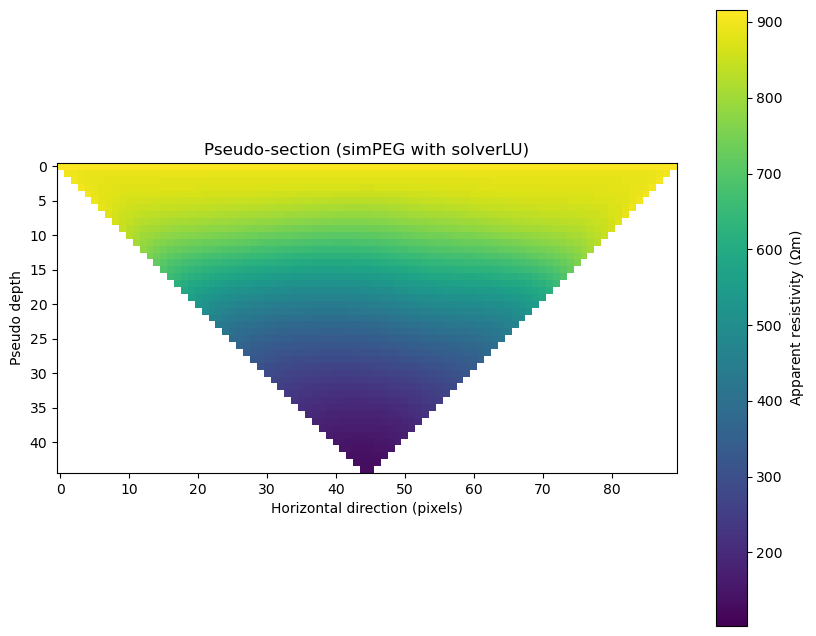

In [74]:
if array == wenner_array:
    process_pseudo_section = process_pseudo_section_wenner_array
else:
    process_pseudo_section = process_pseudo_section_schlumberger_array

pseudo_section_simPEG_solver_LU = process_pseudo_section(forward_model_simPEG_solver_LU, num_electrodes)

vmin = min(np.nanmin(pseudo_section_simPEG), np.nanmin(pseudo_section_pyGIMLi))
vmax = max(np.nanmax(pseudo_section_simPEG), np.nanmax(pseudo_section_pyGIMLi))
norm = Normalize(vmin=vmin, vmax=vmax)

# Plot the pseudo-sections
fig = plt.figure(figsize=(10, 8))
plt.imshow(pseudo_section_simPEG, cmap="viridis", norm=norm)
plt.title("Pseudo-section (simPEG with solverLU)")
plt.ylabel("Pseudo depth")
plt.xlabel("Horizontal direction (pixels)")

plt.colorbar(norm=norm, label=r"Apparent resistivity ($\Omega$m)")

plt.show()

### Differences beween solevers

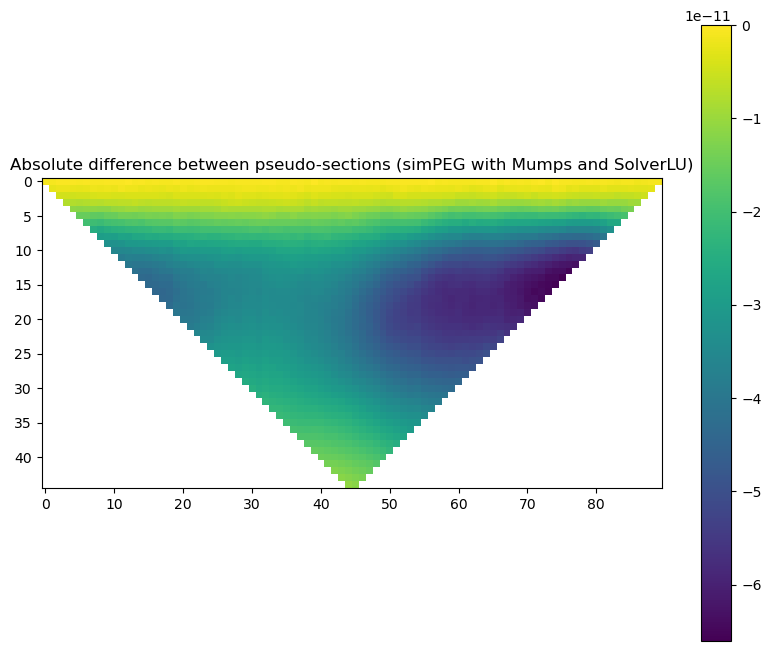

In [73]:
plt.figure(figsize=(10, 8))
plt.imshow(pseudo_section_simPEG - pseudo_section_simPEG_solver_LU, cmap="viridis")
plt.colorbar()
plt.title("Absolute difference between pseudo-sections (simPEG with Mumps and SolverLU)")
plt.show()